# 1. Imports

In [1]:
import locale

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
import seaborn as sns



# 2. Settings

In [2]:
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')
plt.style.use('ggplot')
RANDOM_SEED = 0

# 3. Loading Data

In [72]:
def read_transport_data(filename):
    types_mapping = {
        'Numer / oznaczenie linii' : str,                                     
        'Wariant linii' : str,                                              
        # 'Kurs' : str,                                                        
        'Oznaczenie brygady' : str  
    }

    df = pd.read_csv(filename, sep=';', dtype=types_mapping)
    df = df.drop(columns='Data')
    
    names_mapping = {
        'Numer / oznaczenie linii' : 'Nr linii',                                     
        # 'Wariant linii'                                                    
        # 'Kurs'                                                                
        # 'Oznaczenie brygady'                                                  
        # 'Numer taborowy'                                                     
        # 'Nazwa przystanku'                                                    
        # 'Numer przystanku'                                                   
        'Czas rzeczywisty odjazdu wg. rozkładu' : 'Rzeczywisty czas odjazdu',                              
        'Czas odjazdu z przystanku' : 'Rozkładowy czas odjazdu',                                      
        'Liczba pasażerów w pojeździe przed przystankiem (dane skorygowane)' : 'Liczba pasaz. przed',  
        'Liczba osób które wysiadły (dane skorygowane)' : 'Liczba wysiadających pasaz.',                       
        'Liczba osób które wsiadły (dane skorygowane)' : 'Liczba wsiadajacych pasaz.',                     
        'Liczba pasażerów w pojeździe po odjeździe (dane skorygowane)' : 'Liczba pasaz. po odjezdzie'
    }

    df.rename(columns=names_mapping, inplace=True)
    return df

In [73]:
df = read_transport_data('./data/SZP-2021-09-03.csv')

# 4. Inspecting Data

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177546 entries, 0 to 177545
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Nr linii                     177546 non-null  object
 1   Wariant linii                177546 non-null  object
 2   Kurs                         177546 non-null  object
 3   Oznaczenie brygady           177546 non-null  object
 4   Numer taborowy               177546 non-null  int64 
 5   Nazwa przystanku             177546 non-null  object
 6   Numer przystanku             177546 non-null  int64 
 7   Rzeczywisty czas odjazdu     172273 non-null  object
 8   Rozkładowy czas odjazdu      177546 non-null  object
 9   Liczba pasaz. przed          177546 non-null  int64 
 10  Liczba wysiadających pasaz.  177546 non-null  int64 
 11  Liczba wsiadajacych pasaz.   177546 non-null  int64 
 12  Liczba pasaz. po odjezdzie   177546 non-null  int64 
dtypes: int64(6), o

In [75]:
df.sample(5)

,Nr linii,Wariant linii,Kurs,Oznaczenie brygady,Numer taborowy,Nazwa przystanku,Numer przystanku,Rzeczywisty czas odjazdu,Rozkładowy czas odjazdu,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie
48185,159,TP-BLC,12:52,1,9533,Białobrzeska,2,13:27:00,13:30,24,1,3,26
44228,157,TP-SZC,12:19,4,9431,os.Potok,1,12:24:00,12:25,11,1,0,10
152912,719,TP-JAN,20:54,2,9825,Konarskiego,1,21:38:00,21:38,8,0,0,8
81819,193,TP-BOK,17:50,2,9935,SGGW-Rektorat,2,18:01:00,18:01:00,3,0,0,3
137553,520,TP-PLB,17:45,4,9937,Płowiecka,3,17:55:00,18:00:00,25,2,0,23


In [82]:
df.describe()

,Numer taborowy,Numer przystanku,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie
count,177544.000000,177544.000000,177544.000000,177544.000000,177544.000000,177544.000000
mean,9513.375727,3.437796,12.060869,1.560453,1.570506,12.070923
std,265.046281,7.857913,12.341719,3.136500,3.192505,12.335736
min,9061.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,9319.000000,1.000000,4.000000,0.000000,0.000000,4.000000
50%,9452.000000,2.000000,9.000000,0.000000,0.000000,9.000000
75%,9806.000000,3.000000,16.000000,2.000000,2.000000,16.000000
max,9955.000000,88.000000,133.000000,124.000000,110.000000,133.000000


# 4.1. Check data

In [81]:
counter = 0
counter += len(df.loc[df['Liczba pasaz. przed'] - df['Liczba wysiadających pasaz.'] + df['Liczba wsiadajacych pasaz.'] != df['Liczba pasaz. po odjezdzie']])
counter += len(df[df['Liczba pasaz. przed'] < 0])
print(f'Amount of invalid data: {counter}')

Amount of invalid data: 0


# 4.2. Remove errors

In [80]:
df.drop(df[df['Liczba pasaz. przed'] < 0].index, inplace=True) # remove invlid amout of passengers

# 5. Exploratory Data Analysis (EDA)

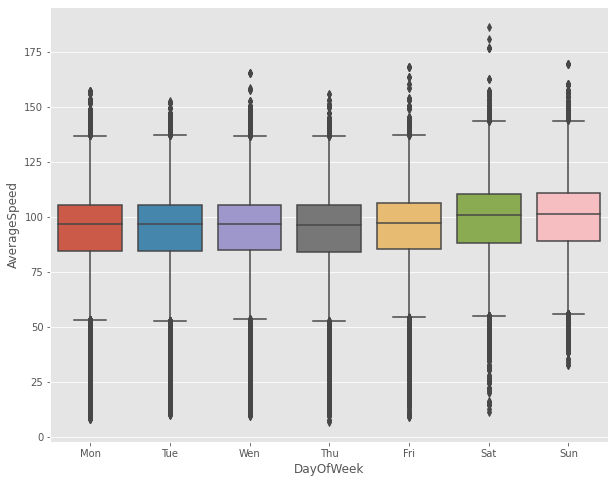

In [13]:
plt.figure(figsize=(10, 8))
ax = sns.boxplot(
    x='DayOfWeek',
    order=['Mon', 'Tue', 'Wen', 'Thu', 'Fri', 'Sat', 'Sun'],
    y='AverageSpeed',
    data=df
)

<Figure size 720x576 with 0 Axes>

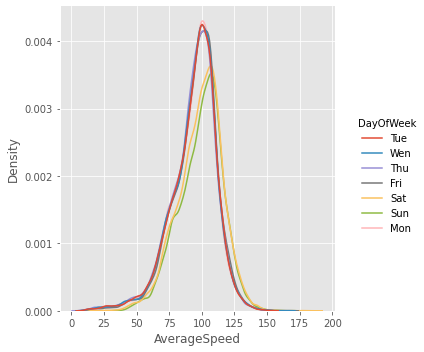

In [14]:
plt.figure(figsize=(10, 8))
ax = sns.displot(
    df,
    x='AverageSpeed',
    hue='DayOfWeek',
    kind='kde'
)

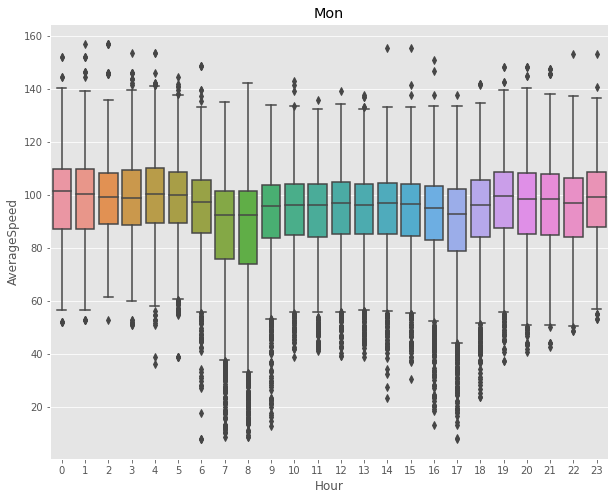

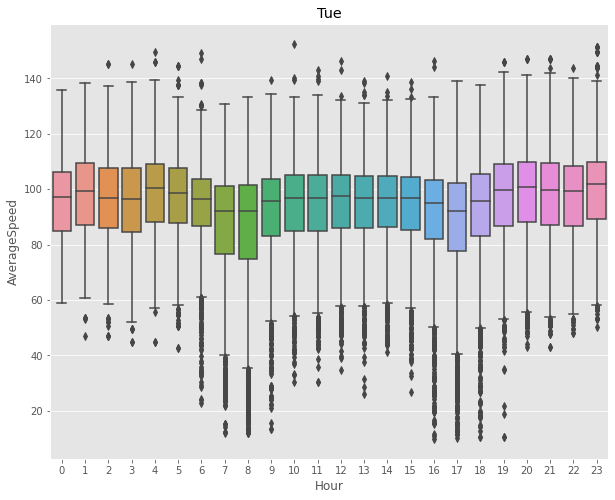

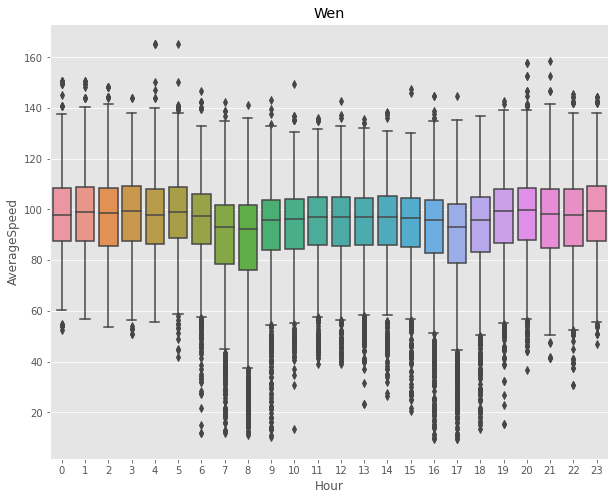

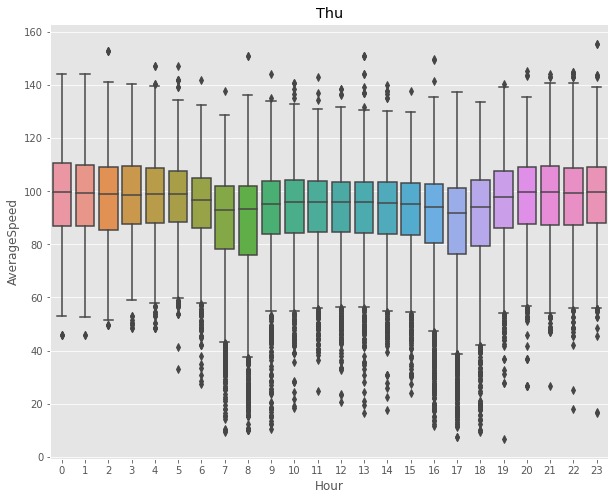

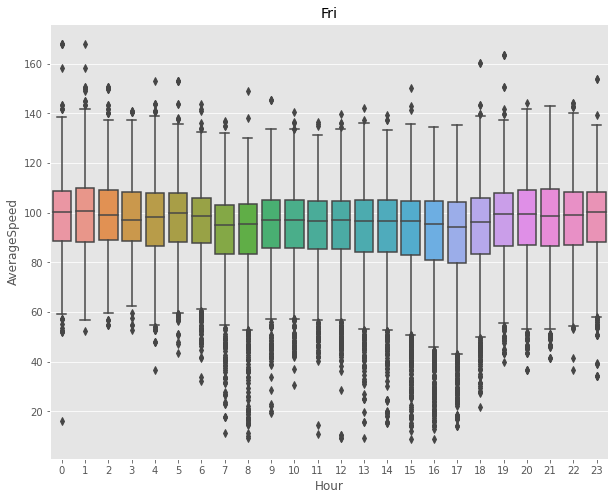

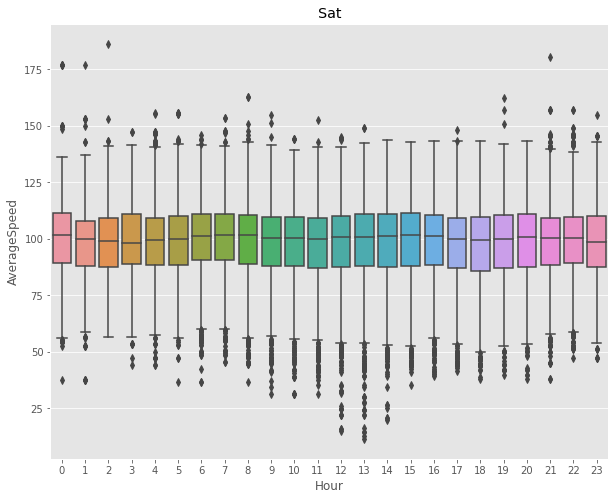

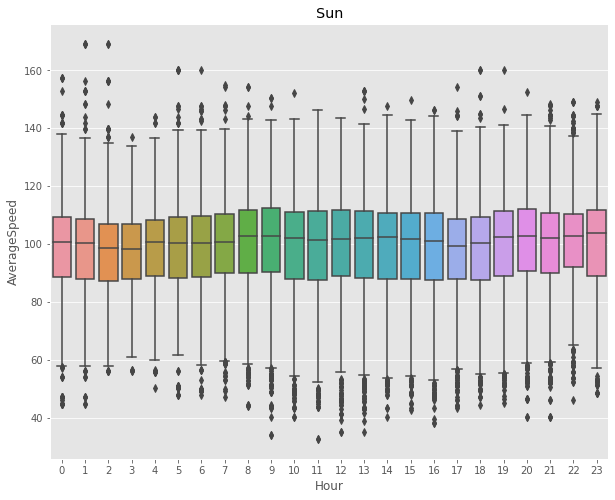

In [15]:
for day in ['Mon', 'Tue', 'Wen', 'Thu', 'Fri', 'Sat', 'Sun']:
    plt.figure(figsize=(10, 8))
    ax = sns.boxplot(
        x='Hour',
        y='AverageSpeed',
        data=df.loc[df['DayOfWeek']==day]
    )
    ax.set_title(day)

# 6. Clustering

In [16]:
def find_clusters(speeds, iterations, df, column):
    k = len(speeds)
    data = np.array(df[column]).reshape(1,-1).T
    clusters = KMeans(
        n_clusters = k,
        max_iter = iterations,
        random_state = RANDOM_SEED
    ).fit(data)
    
    cc, *_ = clusters.cluster_centers_.reshape(1,k)
    cc_ord = np.argsort(cc)
    class_mapping = dict(zip(cc_ord, speeds))
    
    df['class'] = clusters.labels_
    df['class'] = df['class'].map(class_mapping)
    
    return df

In [12]:
speeds = ['low', 'medium', 'high']
iterations = 10

df = find_clusters(speeds, iterations, df, 'AverageSpeed')

<Figure size 720x576 with 0 Axes>

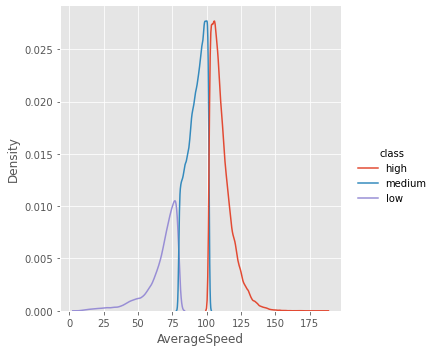

In [13]:
plt.figure(figsize=(10, 8))
ax = sns.displot(
    df,
    x='AverageSpeed',
    hue='class',
    kind='kde'
)

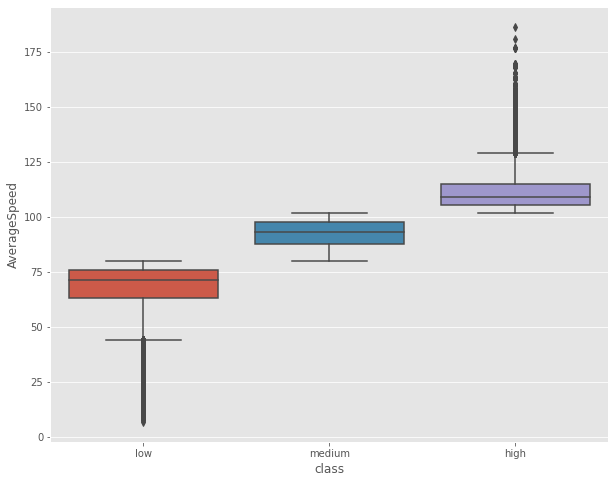

In [14]:
plt.figure(figsize=(10, 8))
ax = sns.boxplot(
    x='class',
    order=speeds,
    y='AverageSpeed',
    data=df
)

# 7. Classification

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [16]:
def create_tree(features, label, df):
    df = df.loc[df['LinkRef']=='AL2031']
    X_train = df[features]
    y_train = df[label]
    
    days = ['Mon', 'Tue', 'Wen', 'Thu', 'Fri', 'Sat', 'Sun']
    X_train = pd.get_dummies(X_train, columns=['DayOfWeek'], prefix=["is"])
    
    clf = DecisionTreeClassifier(
        random_state = RANDOM_SEED,
        max_depth = 3,
        criterion = 'gini'
    )
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    
    cr = classification_report(
        y_train, 
        y_pred, 
        target_names=clf.classes_,
        zero_division=0
    )
    print(cr)
    
    cm = confusion_matrix(
        y_train, 
        y_pred, 
        labels=clf.classes_
    )
    
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=clf.classes_
    )
    disp.plot()
    
    plt.figure(figsize=(80, 60))
    plot_tree(
        clf, 
        filled = True,
        rounded = True,
        label = 'all',
        class_names = clf.classes_
    )
    return clf

              precision    recall  f1-score   support

        high       0.00      0.00      0.00        25
         low       0.75      0.99      0.85      1575
      medium       0.68      0.09      0.15       546

    accuracy                           0.75      2146
   macro avg       0.48      0.36      0.34      2146
weighted avg       0.72      0.75      0.67      2146



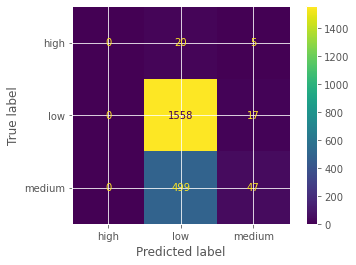

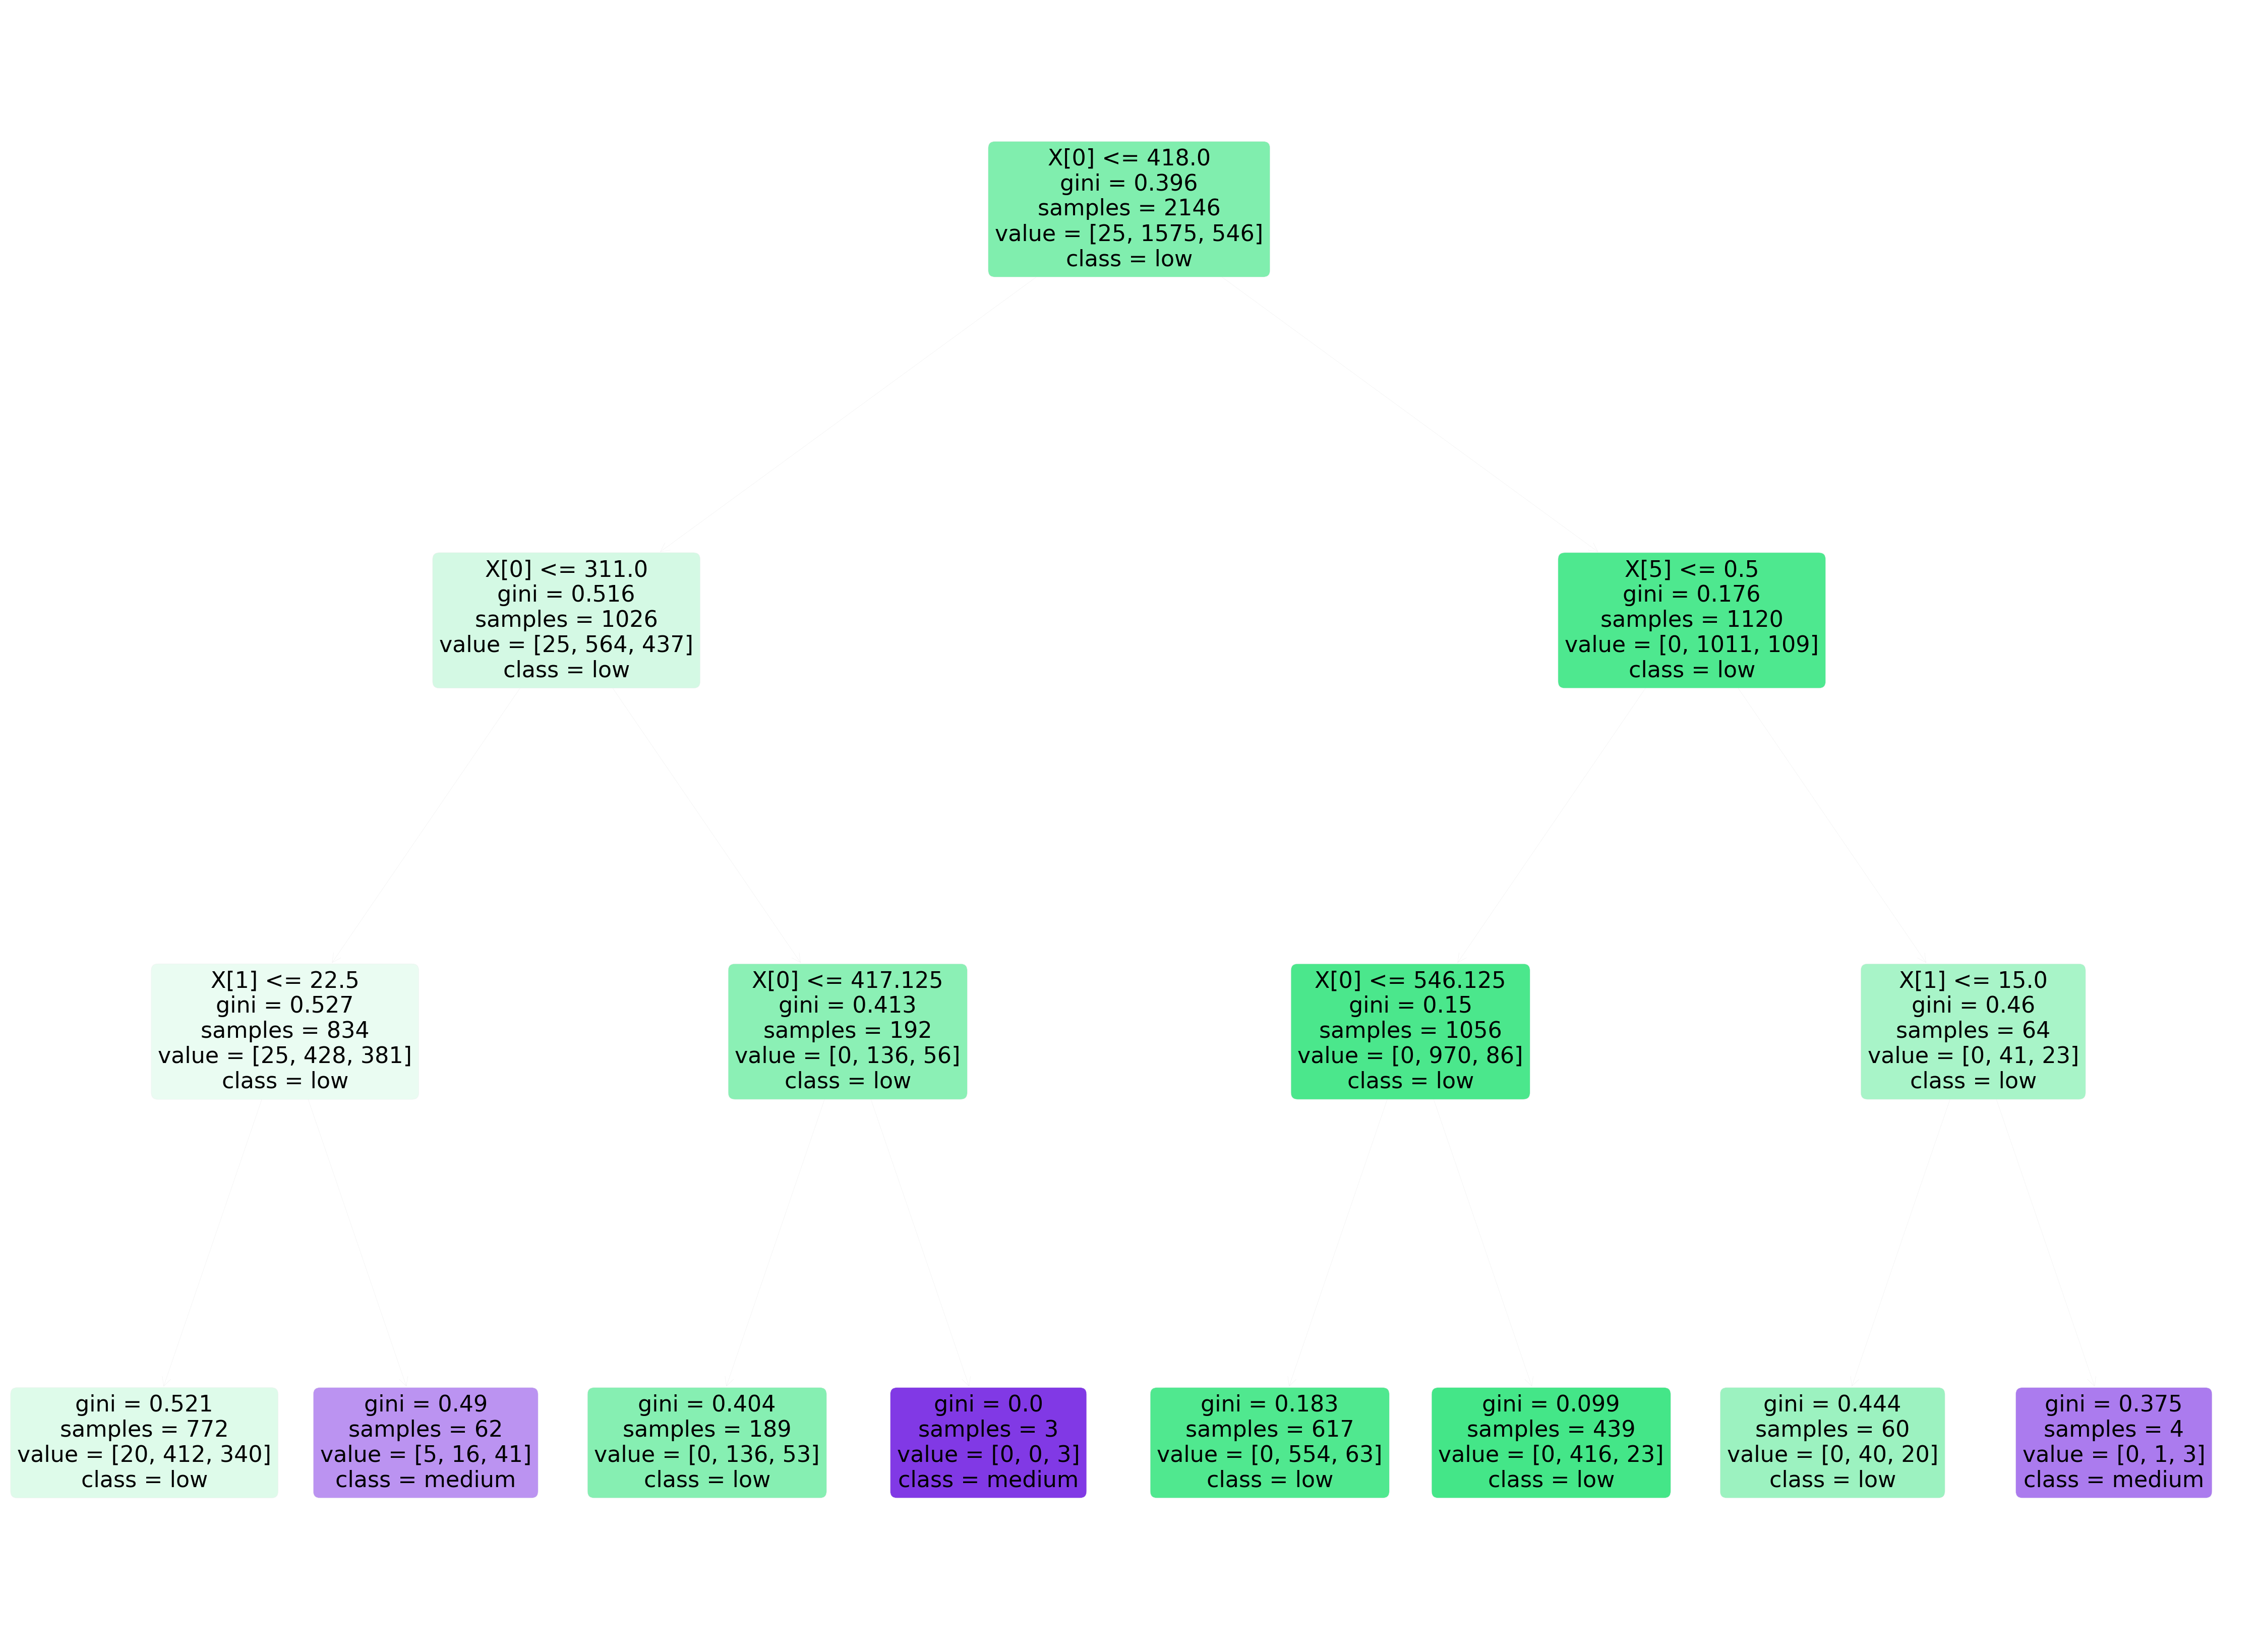

In [17]:
features = ['Flow', 'Hour', 'DayOfWeek']

tree = create_tree(features, 'class', df)

# 8. Testing Set

In [18]:
df2=read_traffic_data('MAR15.csv')

In [19]:
statistics = df.groupby('class').agg(Min=('AverageSpeed', 'min'), Max=('AverageSpeed','max')).sort_values(['Min'])  
statistics

,Min,Max
class,,
low,6.67,79.67
medium,79.68,101.62
high,101.63,186.30


In [20]:
for i in range(len(speeds)):
    if i == 0:
        df2.loc[df2['AverageSpeed'] <= statistics['Max'][speeds[i]], ['class']] = speeds[i]
    elif i== len(speeds):
        df2.loc[df2['AverageSpeed'] >= statistics['Min'][speeds[i]], ['class']] = speeds[i]
    else:
        df2.loc[((df2['AverageSpeed'] >= statistics['Min'][speeds[i]]) & 
                 (df2['AverageSpeed'] <= statistics['Max'][speeds[i]])), ['class']] = speeds[i]

In [21]:
df2 = df2.loc[df2['LinkRef']=='AL2031']
X_test = df2[features]
y_test = df2['class']

X_test = pd.get_dummies(X_test, columns=['DayOfWeek'], prefix=["is"])

In [22]:
y_pred_test = tree.predict(X_test)

              precision    recall  f1-score   support

        high       0.00      0.00      0.00        32
         low       0.70      0.98      0.82      1652
      medium       0.57      0.05      0.10       701

    accuracy                           0.70      2385
   macro avg       0.42      0.35      0.31      2385
weighted avg       0.65      0.70      0.60      2385



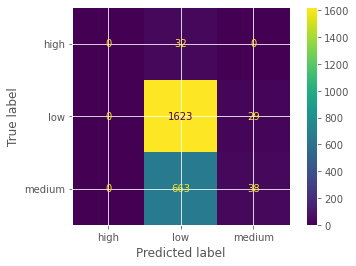

In [23]:
cr = classification_report(
        y_test, 
        y_pred_test, 
        target_names=tree.classes_,
        zero_division=0
    )
cm = confusion_matrix(
        y_test, 
        y_pred_test, 
        labels=tree.classes_
    )
    
disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=tree.classes_
    )
disp.plot()
    

print(cr)

# 9. Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
def create_random_forest(features, labels, df, df2, n_estimators):
    df = df.loc[df['LinkRef']=='AL2031']
    df2 = df2.loc[df2['LinkRef']=='AL2031']
    X_train = df[features]
    y_train = df[labels]

    X_train = pd.get_dummies(X_train, columns=['DayOfWeek'], prefix=["is"])
    
    X_test = df2[features]
    y_test = df2[labels]
    X_test = pd.get_dummies(X_test, columns=['DayOfWeek'], prefix=["is"])

    rf = RandomForestRegressor(n_estimators = n_estimators, random_state = 0)    
    rf.fit(X_train, y_train)
    
    y_rf_pred = rf.predict(X_train)
    y_rf_pred_test = rf.predict(X_test)
    
    
    errors_train = np.array(abs(y_rf_pred - y_train))
    errors_test = np.array(abs(y_rf_pred_test - y_test))
    
    print("MAE train:", round(np.mean(errors_train), 2), '\n'
    "MAE test:", round(np.mean(errors_test), 2))
    
    MAPE_train = errors_train/y_train
    train_acc = 100 - 100*np.mean(MAPE_train)

    MAPE_test = errors_test/y_test
    test_acc = 100 - 100*np.mean(MAPE_test)

    print("Train accuracy:", round(train_acc,2), '\n'
    "Test accuracy:", round(test_acc,2))
    
    return rf, y_rf_pred, y_rf_pred_test, errors_train, errors_test, X_train

In [31]:
features = ['DayOfWeek', 'TimePeriod']
labels = 'AverageSpeed'

In [35]:
rf, y_rf_pred, y_rf_pred_test, errors_train, errors_test, X_train = create_random_forest(features, labels, df, df2, n_estimators = 30)

MAE train: 6.14 
MAE test: 8.14
Train accuracy: 88.98 
Test accuracy: 87.21


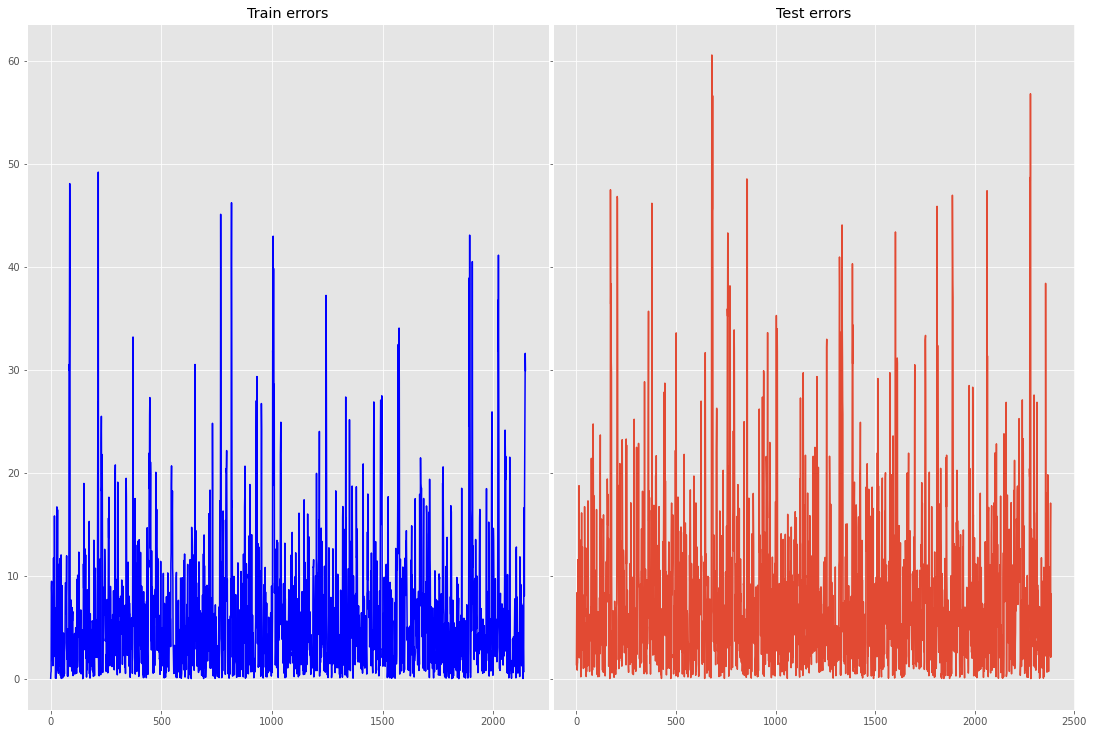

In [36]:
fig, axs = plt.subplots(1,2,figsize=(15,10), sharey = True)
axs[0].plot(errors_train, label = 'Train errors', color = 'blue') 
axs[1].plot(errors_test, label = 'Test errors')
axs[0].title.set_text("Train errors")
axs[1].title.set_text("Test errors")


fig.tight_layout(pad=0.0)

In [37]:
feature_names = [f'feature {i}' for i in range(X_train.shape[1])]
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)

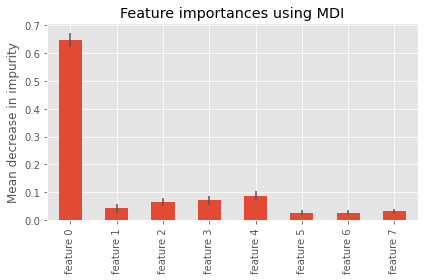

In [38]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()